In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt


In [2]:
os.chdir("D:/dataset/COMP5703/ana")
data = pd.read_excel("data2.xlsx")


In [3]:
def extract_parts(pw):
    match = re.match(r"GRT(\d{4})([^_]+)_([^_]+)_([^_]+)", pw)
    if match:
        return match.groups()
    return [None, None, None, None]

data[['code_4digit', 'part1', 'part2', 'part3']] = data['password'].apply(lambda x: pd.Series(extract_parts(x)))
data['part2'] = data['part2'].str[4:]


In [4]:
part1_counts = data.groupby('peaksf')['part1'].value_counts().unstack(fill_value=0)
part2_counts = data.groupby('peaksf')['part2'].value_counts().unstack(fill_value=0)
part3_counts = data.groupby('peaksf')['part3'].value_counts().unstack(fill_value=0)


In [5]:
bl_df = data[data['part1'] == 'BL'][['code_4digit', 'peaksf']].rename(columns={'peaksf': 'peaksf_BL'})
week6_df = data[data['part1'] == '6week'][['code_4digit', 'peaksf']].rename(columns={'peaksf': 'peaksf_6week'})
merged_df = pd.merge(bl_df, week6_df, on='code_4digit', how='inner')
merged_df['diff'] = merged_df['peaksf_6week'] - merged_df['peaksf_BL']

diff_counts = merged_df['diff'].value_counts().sort_index()
diff_ratios = (diff_counts / diff_counts.sum()).round(4)

diff_summary = pd.DataFrame({
    'diff_value': diff_counts.index,
    'count': diff_counts.values,
    'ratio': diff_ratios.values
})

def classify_diff(val):
    if val == 0:
        return '0'
    elif abs(val) == 1:
        return '|1|'
    else:
        return '>1'

diff_summary['category'] = diff_summary['diff_value'].apply(classify_diff)
grouped_diff = diff_summary.groupby('category').agg({'count': 'sum', 'ratio': 'sum'}).reset_index()


In [6]:
def group_label(val):
    if val == 0:
        return '0'
    elif val == 1:
        return '1'
    else:
        return '>1'

part1_counts['group'] = part1_counts.index.map(group_label)
grouped_counts1 = part1_counts.groupby('group')[['BL', '6week', '3month']].sum().T
proportions1 = grouped_counts1.div(grouped_counts1.sum(axis=1), axis=0)


In [7]:
columns = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '14', '15', '16', '19', '26']
part2_counts.columns = ['00'] + columns
part2_counts['error'] = part2_counts.index.map(group_label)
grouped_counts2 = part2_counts.groupby('error').sum().T
proportions2 = grouped_counts2.div(grouped_counts2.sum(axis=1), axis=0)
proportions2 = proportions2.loc[:, (grouped_counts2.sum(axis=0) > 0)]


In [8]:
part3_counts['error'] = part3_counts.index.map(group_label)
grouped_counts3 = part3_counts.groupby('error').sum().T
proportions3 = grouped_counts3.div(grouped_counts3.sum(axis=1), axis=0)
proportions3 = proportions3.loc[:, (grouped_counts3.sum(axis=0) > 0)]


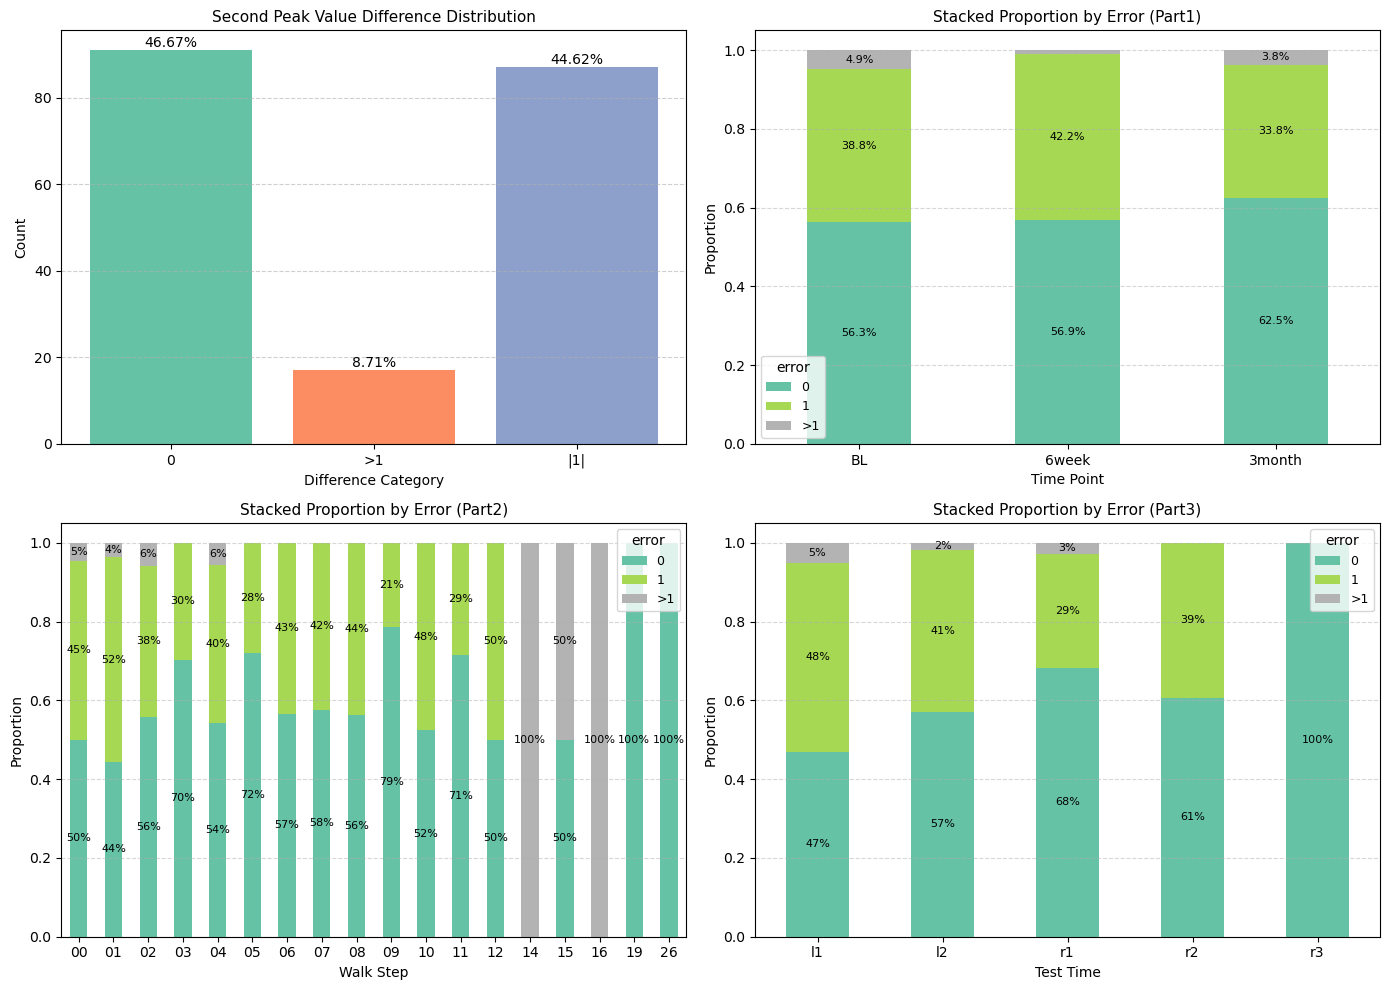

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
font_size = 10

# 图1：差值柱状图
bars = axs[0].bar(grouped_diff['category'], grouped_diff['count'], color=['#66c2a5', '#fc8d62', '#8da0cb'])
for bar, ratio in zip(bars, grouped_diff['ratio']):
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{ratio:.2%}',
                ha='center', va='bottom', fontsize=font_size)
axs[0].set_xlabel('Difference Category', fontsize=font_size)
axs[0].set_ylabel('Count', fontsize=font_size)
axs[0].set_title('Second Peak Value Difference Distribution', fontsize=font_size + 1)
axs[0].grid(axis='y', linestyle='--', alpha=0.6)

# 图2：part1 堆叠图
proportions1.plot(kind='bar', stacked=True, colormap='Set2', ax=axs[1])
axs[1].set_xticklabels(proportions1.index, rotation=0, fontsize=font_size)
axs[1].set_ylabel('Proportion', fontsize=font_size)
axs[1].set_xlabel('Time Point', fontsize=font_size)
axs[1].set_title('Stacked Proportion by Error (Part1)', fontsize=font_size + 1)
axs[1].legend(title='error', fontsize=font_size - 1)
axs[1].grid(axis='y', linestyle='--', alpha=0.5)
for i, row in enumerate(proportions1.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            axs[1].text(i, cum_height + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=8)
        cum_height += height

# 图3：part2 堆叠图
proportions2.plot(kind='bar', stacked=True, colormap='Set2', ax=axs[2])
axs[2].set_xticklabels(proportions2.index, rotation=0, fontsize=font_size)
axs[2].set_ylabel('Proportion', fontsize=font_size)
axs[2].set_xlabel('Walk Step', fontsize=font_size)
axs[2].set_title('Stacked Proportion by Error (Part2)', fontsize=font_size + 1)
axs[2].legend(title='error', fontsize=font_size - 1)
axs[2].grid(axis='y', linestyle='--', alpha=0.5)
for i, row in enumerate(proportions2.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            axs[2].text(i, cum_height + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=8)
        cum_height += height

# 图4：part3 堆叠图
proportions3.plot(kind='bar', stacked=True, colormap='Set2', ax=axs[3])
axs[3].set_xticklabels(proportions3.index, rotation=0, fontsize=font_size)
axs[3].set_ylabel('Proportion', fontsize=font_size)
axs[3].set_xlabel('Test Time', fontsize=font_size)
axs[3].set_title('Stacked Proportion by Error (Part3)', fontsize=font_size + 1)
axs[3].legend(title='error', fontsize=font_size - 1)
axs[3].grid(axis='y', linestyle='--', alpha=0.5)
for i, row in enumerate(proportions3.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            axs[3].text(i, cum_height + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=8)
        cum_height += height

plt.tight_layout()
plt.show()
